In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from matplotlib import pyplot

In [16]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [17]:
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [19]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var='Appliances', dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [20]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2','T9','T6','Windspeed'], axis=1)
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,  92.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,  92.        ,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,  92.        ,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,  56.33333333,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,  56.66666667,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,  57.        ,
         27.        ,  13.2       ]])

In [21]:
def treino_lstm(data, neurons, batch_size, epochs,train_size):
    values = data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    scaled = pd.DataFrame(scaled,columns = list(data.columns))
    reframed = series_to_supervised_miso(scaled, 1, 1)
    
    values = reframed.values
    train_size=int(len(values) * train_size)
    
    train_X, train_y = values[:train_size], values[:train_size]
    train_X, train_y = train_X[:, :-1], train_y[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    
    test_X, test_y = values[train_size:], values[train_size:]
    test_X, test_y = test_X[:, :-1], test_y[:, -1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    neurons = neurons
    batch_size = batch_size
    epochs = epochs
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    # plot history
    pyplot.clf()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pyplot.close('all')
    
    return model

In [41]:
def test_lstm(data, model, train_size):
    values = data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    scaled = pd.DataFrame(scaled,columns = list(data.columns))
    reframed = series_to_supervised_miso(scaled, 1, 1)
    
    values = reframed.values
    train_size=int(len(values) * train_size)
    test_size = int(len(values)) - train_size
    
    test_X, test_y = values[train_size:], values[train_size:]
    test_X, test_y = test_X[:, :-1], test_y[:, -1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    
    yhat = model.predict(test_X)
    
    return yhat,test_X, test_y, scaler

Epoch 1/75
592/592 [==============================] - 3s 3ms/step - loss: 0.0102 - val_loss: 0.0068
Epoch 2/75
592/592 [==============================] - 3s 4ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 3/75
592/592 [==============================] - 3s 4ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 4/75
592/592 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 5/75
592/592 [==============================] - 2s 3ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 6/75
592/592 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 7/75
592/592 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 8/75
592/592 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 9/75
592/592 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 10/75
592/592 [==============================] - 2s 3ms/step - loss: 0.0048 - val_loss: 0.0037

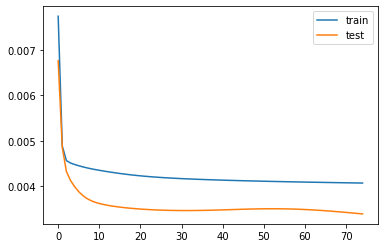

In [50]:
neurons = 25
batch_size = 25
epochs = 75
train_size = 0.75
model = treino_lstm(data, neurons, batch_size, epochs,train_size)
    
    

In [51]:
yhat,test_X, test_y,scaler = test_lstm(data, model, train_size)

In [52]:
from sklearn.metrics import mean_squared_error
# make a prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 62.354
Test MAPE: 30.595
Test SMAPE: 16.433


In [7]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'RH_9',
       'T_out', 'Press_mm_hg', 'RH_out', 'Visibility', 'Tdewpoint'],
      dtype='object')

In [8]:
len(data.columns)

23

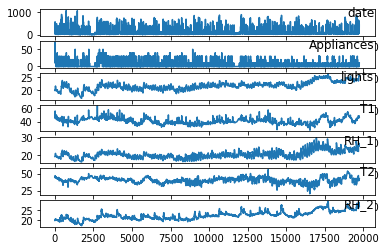

In [48]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
pyplot.close('all')

In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled,columns = list(data.columns))
# frame as supervised learning
reframed = series_to_supervised_miso(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_7(t-1),T8(t-1),RH_8(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,0.046729,0.428571,0.327350,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.653428,0.173329,0.661412,0.677290,0.372990,0.097674,0.894737,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.327350,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.651064,0.173329,0.660155,0.678532,0.369239,0.100000,0.894737,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.327350,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.646572,0.173329,0.655586,0.676049,0.365488,0.102326,0.894737,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.327350,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.641489,0.164175,0.650788,0.671909,0.361736,0.104651,0.894737,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.327350,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.639362,0.164175,0.650788,0.671909,0.357985,0.106977,0.894737,0.717949,0.520362,0.037383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,0.074766,0.000000,0.923266,0.545913,0.718052,0.620602,0.841088,0.575946,0.864865,0.766823,...,0.764691,0.765334,0.714359,0.727580,0.896034,0.602326,0.412281,0.335897,0.903469,0.084112
19731,0.084112,0.000000,0.926786,0.537657,0.711655,0.606309,0.830841,0.579374,0.864865,0.765258,...,0.755319,0.768386,0.701645,0.729443,0.891747,0.602326,0.416667,0.348718,0.901961,0.074766
19732,0.074766,0.000000,0.919747,0.536006,0.701769,0.607836,0.825302,0.582178,0.864865,0.765258,...,0.752280,0.768386,0.691912,0.729443,0.887460,0.602326,0.421053,0.361538,0.900452,0.242991
19733,0.242991,0.142857,0.919747,0.538666,0.692651,0.627198,0.818378,0.603988,0.864865,0.771233,...,0.751773,0.768386,0.687457,0.729443,0.883173,0.602326,0.425439,0.374359,0.898944,0.383178


In [50]:
len(reframed.values)

19734

In [51]:
values = reframed.values
train_size=int(len(values) *0.75)
test_size = int(len(values)) - train_size
print(test_size)

4934


In [42]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 1, 23) (14800,) (4934, 1, 23) (4934,)


In [53]:
train_y

array([0.04672897, 0.03738318, 0.03738318, ..., 0.27102804, 0.27102804,
       0.25233645])

In [30]:
test_y

array([0.25233645, 0.28971963, 0.3271028 , ..., 0.24299065, 0.38317757,
       0.39252336])

In [15]:
# design network
neurons = 50
batch_size = 72
epochs = 50
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [16]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                14800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 14,851
Trainable params: 14,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
206/206 [==============================] - 3s 6ms/step - loss: 0.0119 - val_loss: 0.0066
Epoch 2/50
206/206 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 3/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 4/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/50
206/206 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 6/50
206/206 [==============================] - 1s 4ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 7/50
206/206 [==============================] - 1s 4ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 8/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 9/50
206/206 [==============================] - 1s 4ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 10/50
206/206 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0034

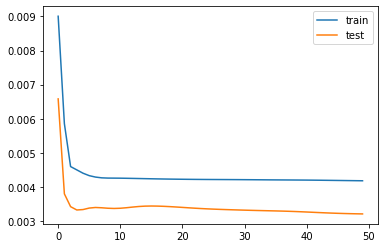

In [17]:
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.clf()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('loss.png')
pyplot.close('all')

In [18]:
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 60.632
Test MAPE: 32.391
Test SMAPE: 14.277


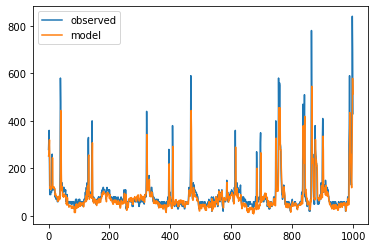

In [19]:
# plot baseline and predictions
pyplot.clf()
pyplot.plot(inv_y[0:1000], label="observed")
pyplot.plot(inv_yhat[0:1000], label="model")
pyplot.legend()
pyplot.show()
#pyplot.savefig('test_and_train.png')
pyplot.close('all')

In [46]:
# data_s = reframed
# data_s

In [47]:
# def format_data(window=30):
#     # arrange data to LSTM input and output with specified window
#     X = []
#     y = []
#     for i in range(window,len(data_s)):
#         X.append(data_s[i-window:i])
#         y.append(data_s[i,1])
    
#     # Format to array for LSTM input
#     X, y = np.array(X), np.array(y)
    
#     # Split into train and test
#     Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,shuffle=False)        
    
#     return Xtrain, ytrain, Xtest, ytest

In [48]:
# def forecast(Xtest,ytest,model,window):
#     Yr = ytest
#     Yp = model.predict(Xtest)
#     Yf = ytest.copy()
#     for i in range(len(Yf)):
#         if i < window:
#             pass
#         else:
#             XQ = Xtest[i,:,0]
#             XT = Yf[i-window:i]
#             Xf = np.vstack((XQ,XT)).T
#             Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
#             Yf[i] = model.predict(Xf)[0] 
            
#     return Yr, Yp, Yf

In [66]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 1, 23) (14800,) (4934, 1, 23) (4934,)


In [67]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int

# space = {'rate'       : hp.uniform('rate',0.01,0.5),
#          'units'      : scope.int(hp.quniform('units',10,100,5)),
#          'batch_size' : scope.int(hp.quniform('batch_size',10,100,25)),
#          'layers'     : scope.int(hp.quniform('layers',1,6,1)),
#          'epochs'     : scope.int(hp.quniform('epochs',50,100,25)),
#          'optimizer'  : hp.choice('optimizer',['adadelta','adam','rmsprop','adagrad']),
#          'activation' : hp.choice('activation',['relu', 'tanh', 'sigmoid','exponential'])
#         }


space = {'rate'       : hp.uniform('rate',0.001,0.1,0.1),
         'units'      : scope.int(hp.quniform('units',10,100,5)),
         'batch_size' : scope.int(hp.quniform('batch_size',10,100,25)),
         'layers'     : scope.int(hp.quniform('layers',1,6,1)),
         'epochs'     : scope.int(hp.quniform('epochs',50,100,25)),
         'optimizer'  : hp.choice('optimizer',['adam']),
         'activation' : hp.choice('activation',['relu', 'tanh', 'sigmoid'])
        }


In [73]:
def f_nn(params):
    # Generate data with given window
    #Xtrain, ytrain, Xtest, ytest = format_data(window=params['window'])
    # split into train and test sets
    train_X, train_y = values[:train_size], values[:train_size]
    test_X, test_y = values[train_size:], values[train_size:]

    # split into input (all columns exceptc last one) and outputs (last column)
    train_X, train_y = train_X[:, :-1], train_y[:, -1]
    test_X, test_y = test_X[:, :-1], test_y[:, -1]

    # reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # Keras LSTM model
    model = Sequential()
    
    if params['layers'] == 1:
        model.add(LSTM(units=params['units'], input_shape=(train_X.shape[1], train_X.shape[2]),activation=params['activation']))
        model.add(Dense(1))
        model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]),activation=params['activation']))
        model.add(Dropout(rate=params['rate']))
        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(LSTM(units=params['units'],return_sequences=True,activation=params['activation']))
            model.add(Dropout(rate=params['rate']))
        # Last layer doesn't return anything
        model.add(LSTM(units=params['units']))
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(1))
    model.compile(optimizer=params['optimizer'], loss='mse')
    
    es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)

    result = model.fit(train_X, train_y, verbose=0, validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       callbacks = [es,TqdmCallback(verbose=1)]
                      )
        #get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss'])
    pyplot.clf()
    pyplot.plot(result.history['loss'], label='train')
    pyplot.plot(result.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pyplot.close('all')
#     print('Best validation loss of epoch:', validation_loss)
    #val_length = int(0.2*len(test_y))
    #Xval, yval = train_X[-val_length:], train_y[-val_length:]
    
    # Evaluate forecast
#     Yr, Yp, Yf = forecast(Xval,yval,model,params['window'])
#     mse = np.mean((Yr - Yf)**2)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    #rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse = Measures.rmse(inv_yhat,inv_y)
    #mape = Measures.mape(inv_yhat,inv_y)
    #smape = Measures.smape(inv_yhat,inv_y)
    print('Best forecast loss of epoch:', rmse)
    # plot baseline and predictions
    pyplot.clf()
    pyplot.plot(inv_y[0:1000], label="observed")
    pyplot.plot(inv_yhat[0:1000], label="model")
    pyplot.legend()
    pyplot.show()
    #pyplot.savefig('test_and_train.png')
    pyplot.close('all')
    
    return {'loss': rmse, 'status': STATUS_OK, 'model': model, 'params': params}

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00039: early stopping                          
  0%|          | 0/2 [02:24<?, ?trial/s, best loss=?]

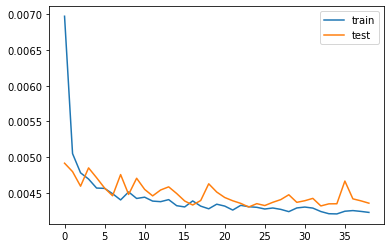

Best forecast loss of epoch:                         
60.45715179720658                                    
  0%|          | 0/2 [02:27<?, ?trial/s, best loss=?]

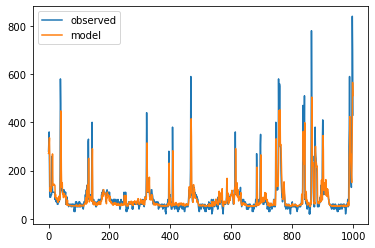

 50%|█████     | 1/2 [02:27<02:27, 147.91s/trial, best loss: 60.45715179720658]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

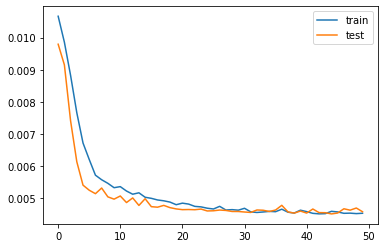

Best forecast loss of epoch:                                                   
61.13636521513251                                                              
 50%|█████     | 1/2 [04:26<02:27, 147.91s/trial, best loss: 60.45715179720658]

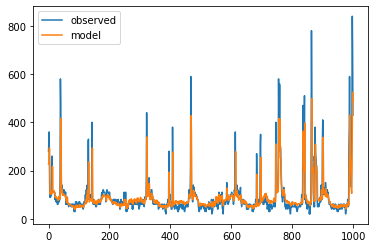

100%|██████████| 2/2 [04:26<00:00, 133.42s/trial, best loss: 60.45715179720658]


In [74]:
evals = 2
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=evals, trials=trials)

best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                          
60.945953106497356                                    
  0%|          | 0/50 [00:30<?, ?trial/s, best loss=?]

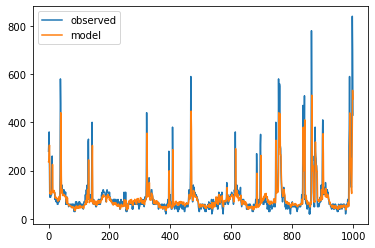

  2%|▏         | 1/50 [00:30<25:03, 30.67s/trial, best loss: 60.945953106497356]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00035: early stopping                                                     
Best forecast loss of epoch:                                                    
88.3518487755697                                                                
  2%|▏         | 1/50 [01:38<25:03, 30.67s/trial, best loss: 60.945953106497356]

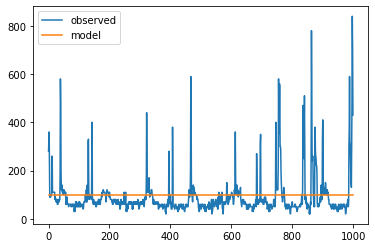

  4%|▍         | 2/50 [01:39<42:18, 52.88s/trial, best loss: 60.945953106497356]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                     
Best forecast loss of epoch:                                                    
63.58114877988334                                                               
  4%|▍         | 2/50 [02:35<42:18, 52.88s/trial, best loss: 60.945953106497356]

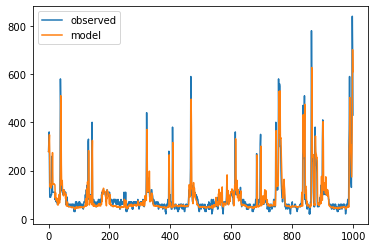

  6%|▌         | 3/50 [02:35<42:38, 54.44s/trial, best loss: 60.945953106497356]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                    
59.87473036090222                                                               
  6%|▌         | 3/50 [03:46<42:38, 54.44s/trial, best loss: 60.945953106497356]

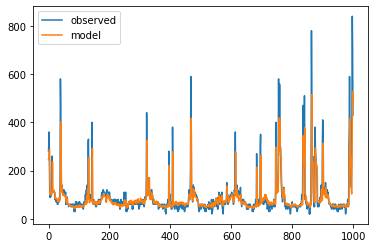

  8%|▊         | 4/50 [03:46<46:48, 61.06s/trial, best loss: 59.87473036090222] 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                   
59.74271939147304                                                              
  8%|▊         | 4/50 [04:36<46:48, 61.06s/trial, best loss: 59.87473036090222]

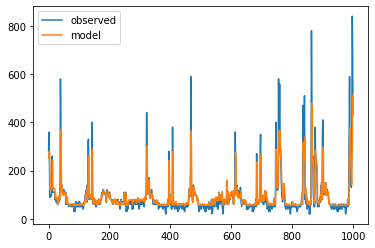

 10%|█         | 5/50 [04:36<42:43, 56.97s/trial, best loss: 59.74271939147304]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00041: early stopping                                                    
Best forecast loss of epoch:                                                   
59.189014998631365                                                             
 10%|█         | 5/50 [05:46<42:43, 56.97s/trial, best loss: 59.74271939147304]

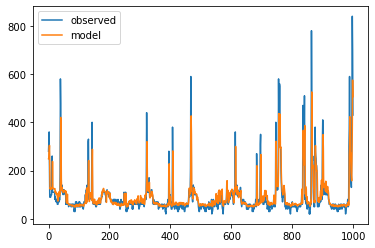

 12%|█▏        | 6/50 [05:47<45:12, 61.66s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                     
Best forecast loss of epoch:                                                    
64.59598418789483                                                               
 12%|█▏        | 6/50 [06:26<45:12, 61.66s/trial, best loss: 59.189014998631365]

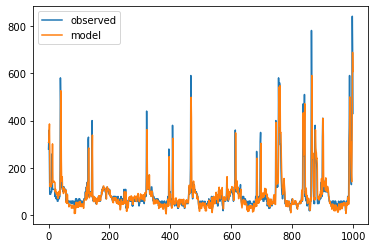

 14%|█▍        | 7/50 [06:26<38:54, 54.30s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00035: early stopping                                                     
Best forecast loss of epoch:                                                    
88.3766537265495                                                                
 14%|█▍        | 7/50 [06:56<38:54, 54.30s/trial, best loss: 59.189014998631365]

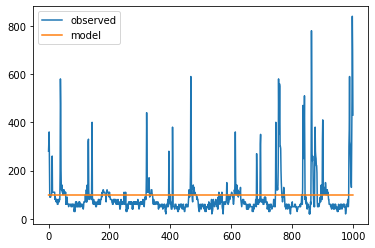

 16%|█▌        | 8/50 [06:56<32:36, 46.58s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                     
Best forecast loss of epoch:                                                    
64.74213948900854                                                               
 16%|█▌        | 8/50 [08:17<32:36, 46.58s/trial, best loss: 59.189014998631365]

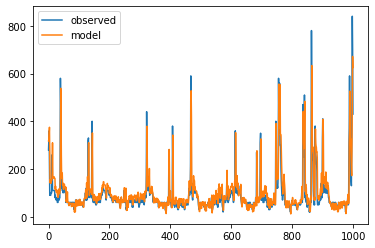

 18%|█▊        | 9/50 [08:17<39:13, 57.41s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                    
59.53627514810003                                                               
 18%|█▊        | 9/50 [10:00<39:13, 57.41s/trial, best loss: 59.189014998631365]

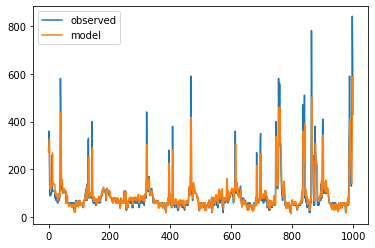

 20%|██        | 10/50 [10:00<47:42, 71.55s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
60.21679259642257                                                                
 20%|██        | 10/50 [10:59<47:42, 71.55s/trial, best loss: 59.189014998631365]

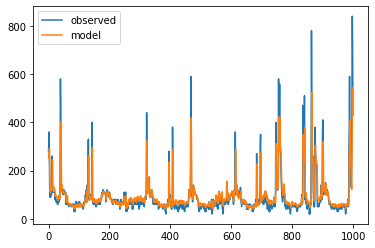

 22%|██▏       | 11/50 [10:59<43:58, 67.65s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00040: early stopping                                                      
Best forecast loss of epoch:                                                     
62.207599389174945                                                               
 22%|██▏       | 11/50 [11:28<43:58, 67.65s/trial, best loss: 59.189014998631365]

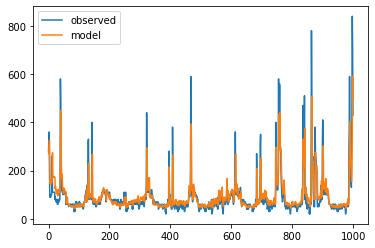

 24%|██▍       | 12/50 [11:29<35:30, 56.06s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
59.90477315203716                                                                
 24%|██▍       | 12/50 [12:50<35:30, 56.06s/trial, best loss: 59.189014998631365]

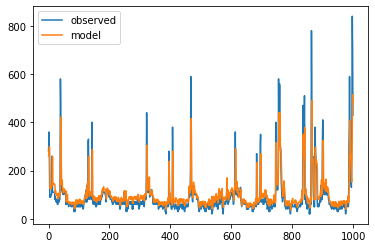

 26%|██▌       | 13/50 [12:50<39:17, 63.70s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                      
Best forecast loss of epoch:                                                     
64.41913747811243                                                                
 26%|██▌       | 13/50 [13:52<39:17, 63.70s/trial, best loss: 59.189014998631365]

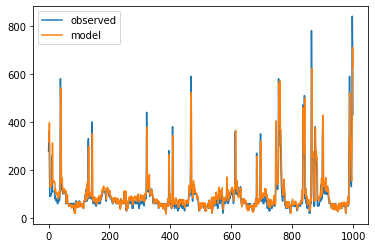

 28%|██▊       | 14/50 [13:52<37:55, 63.22s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
60.84991333909879                                                                
 28%|██▊       | 14/50 [14:47<37:55, 63.22s/trial, best loss: 59.189014998631365]

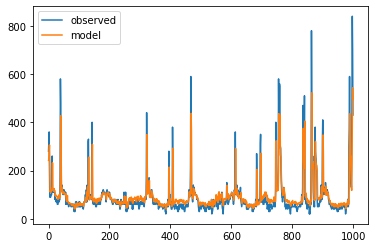

 30%|███       | 15/50 [14:47<35:22, 60.64s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
60.310160313870405                                                               
 30%|███       | 15/50 [15:40<35:22, 60.64s/trial, best loss: 59.189014998631365]

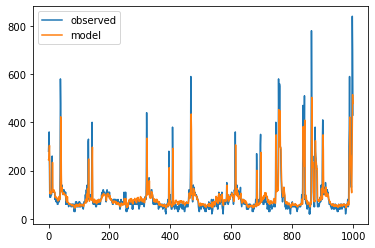

 32%|███▏      | 16/50 [15:40<33:05, 58.39s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00020: early stopping                                                      
Best forecast loss of epoch:                                                     
64.53431850296424                                                                
 32%|███▏      | 16/50 [15:58<33:05, 58.39s/trial, best loss: 59.189014998631365]

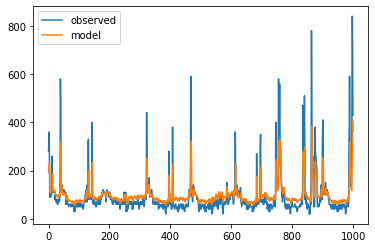

 34%|███▍      | 17/50 [15:59<25:34, 46.50s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
60.53487224689959                                                                
 34%|███▍      | 17/50 [16:51<25:34, 46.50s/trial, best loss: 59.189014998631365]

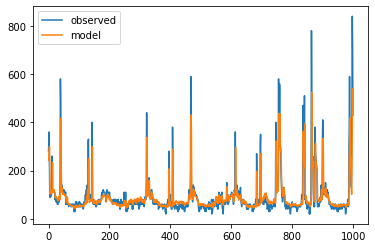

 36%|███▌      | 18/50 [16:51<25:44, 48.25s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
59.600140404122676                                                               
 36%|███▌      | 18/50 [17:47<25:44, 48.25s/trial, best loss: 59.189014998631365]

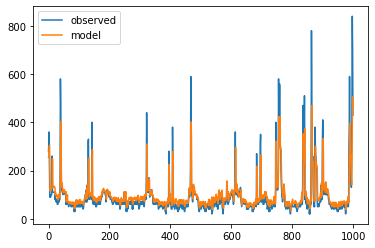

 38%|███▊      | 19/50 [17:47<26:11, 50.69s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
59.96024982477557                                                                
 38%|███▊      | 19/50 [18:32<26:11, 50.69s/trial, best loss: 59.189014998631365]

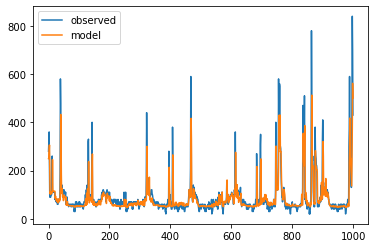

 40%|████      | 20/50 [18:32<24:28, 48.95s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00039: early stopping                                                      
Best forecast loss of epoch:                                                     
59.93596714197655                                                                
 40%|████      | 20/50 [20:48<24:28, 48.95s/trial, best loss: 59.189014998631365]

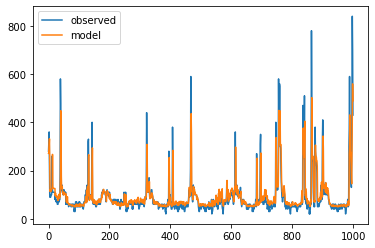

 42%|████▏     | 21/50 [20:48<36:15, 75.00s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
61.824909590699285                                                               
 42%|████▏     | 21/50 [22:31<36:15, 75.00s/trial, best loss: 59.189014998631365]

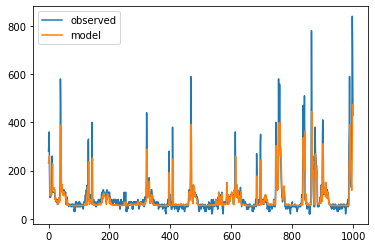

 44%|████▍     | 22/50 [22:31<38:55, 83.41s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00062: early stopping                                                      
Best forecast loss of epoch:                                                     
65.79342607781047                                                                
 44%|████▍     | 22/50 [23:23<38:55, 83.41s/trial, best loss: 59.189014998631365]

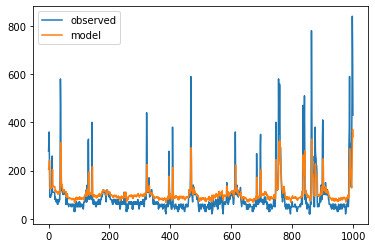

 46%|████▌     | 23/50 [23:23<33:15, 73.92s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                      
Best forecast loss of epoch:                                                     
67.88887631001282                                                                
 46%|████▌     | 23/50 [25:11<33:15, 73.92s/trial, best loss: 59.189014998631365]

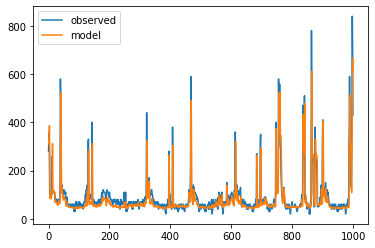

 48%|████▊     | 24/50 [25:11<36:27, 84.15s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00038: early stopping                                                      
Best forecast loss of epoch:                                                     
60.39229768279425                                                                
 48%|████▊     | 24/50 [26:26<36:27, 84.15s/trial, best loss: 59.189014998631365]

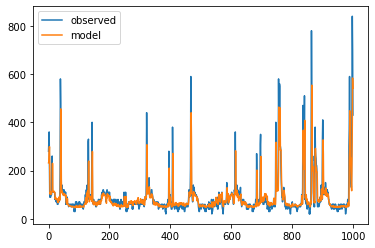

 50%|█████     | 25/50 [26:26<33:56, 81.46s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
59.67132169594699                                                                
 50%|█████     | 25/50 [28:48<33:56, 81.46s/trial, best loss: 59.189014998631365]

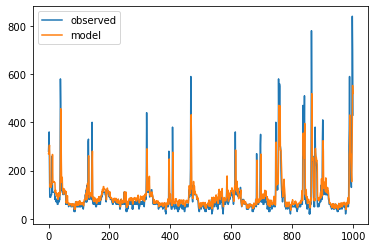

 52%|█████▏    | 26/50 [28:48<39:53, 99.72s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00042: early stopping                                                      
Best forecast loss of epoch:                                                     
59.23591762345294                                                                
 52%|█████▏    | 26/50 [29:48<39:53, 99.72s/trial, best loss: 59.189014998631365]

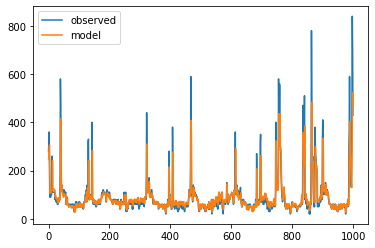

 54%|█████▍    | 27/50 [29:48<33:37, 87.70s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00038: early stopping                                                      
Best forecast loss of epoch:                                                     
60.40580365446553                                                                
 54%|█████▍    | 27/50 [30:55<33:37, 87.70s/trial, best loss: 59.189014998631365]

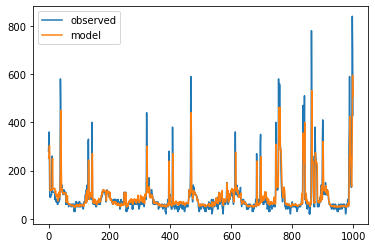

 56%|█████▌    | 28/50 [30:55<29:55, 81.60s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00072: early stopping                                                      
Best forecast loss of epoch:                                                     
59.44849805750422                                                                
 56%|█████▌    | 28/50 [31:43<29:55, 81.60s/trial, best loss: 59.189014998631365]

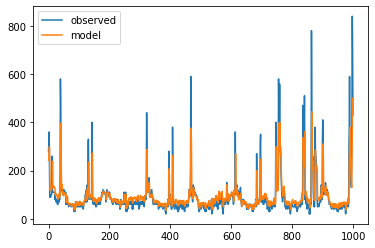

 58%|█████▊    | 29/50 [31:43<24:57, 71.33s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00076: early stopping                                                      
Best forecast loss of epoch:                                                     
64.21741521830816                                                                
 58%|█████▊    | 29/50 [33:10<24:57, 71.33s/trial, best loss: 59.189014998631365]

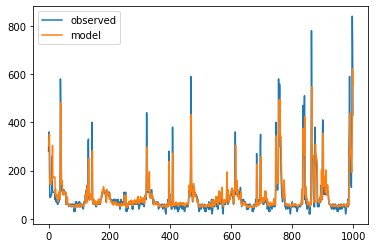

 60%|██████    | 30/50 [33:11<25:26, 76.31s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00100: early stopping                                                      
Best forecast loss of epoch:                                                     
59.33563014203831                                                                
 60%|██████    | 30/50 [34:36<25:26, 76.31s/trial, best loss: 59.189014998631365]

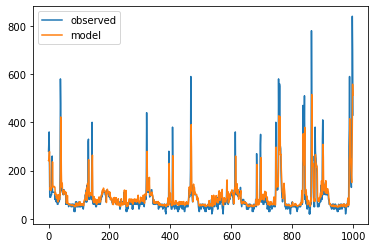

 62%|██████▏   | 31/50 [34:36<25:03, 79.14s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00022: early stopping                                                      
Best forecast loss of epoch:                                                     
59.85843529522914                                                                
 62%|██████▏   | 31/50 [35:40<25:03, 79.14s/trial, best loss: 59.189014998631365]

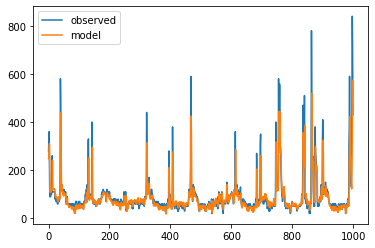

 64%|██████▍   | 32/50 [35:40<22:23, 74.64s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00032: early stopping                                                      
Best forecast loss of epoch:                                                     
63.40327132033566                                                                
 64%|██████▍   | 32/50 [36:30<22:23, 74.64s/trial, best loss: 59.189014998631365]

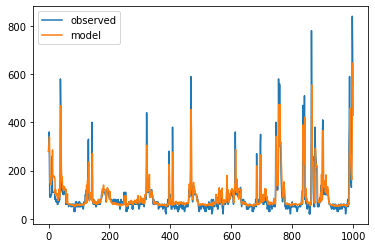

 66%|██████▌   | 33/50 [36:30<18:59, 67.03s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00027: early stopping                                                      
Best forecast loss of epoch:                                                     
62.80998284572523                                                                
 66%|██████▌   | 33/50 [37:02<18:59, 67.03s/trial, best loss: 59.189014998631365]

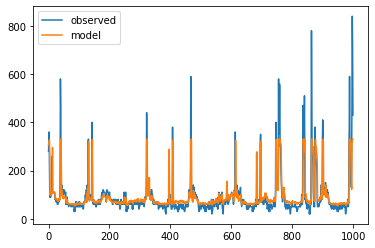

 68%|██████▊   | 34/50 [37:02<15:06, 56.66s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00040: early stopping                                                      
Best forecast loss of epoch:                                                     
59.40049633712206                                                                
 68%|██████▊   | 34/50 [37:45<15:06, 56.66s/trial, best loss: 59.189014998631365]

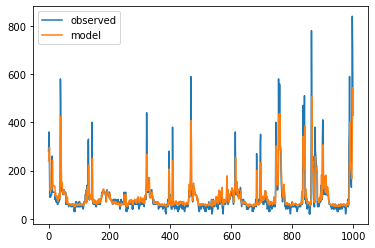

 70%|███████   | 35/50 [37:45<13:09, 52.61s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00061: early stopping                                                      
Best forecast loss of epoch:                                                     
60.82589463133122                                                                
 70%|███████   | 35/50 [39:48<13:09, 52.61s/trial, best loss: 59.189014998631365]

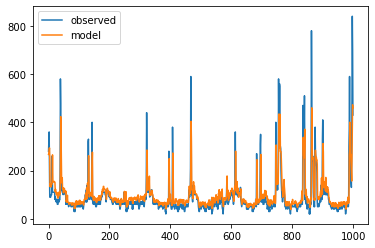

 72%|███████▏  | 36/50 [39:48<17:10, 73.59s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00020: early stopping                                                      
Best forecast loss of epoch:                                                     
88.70057322916766                                                                
 72%|███████▏  | 36/50 [40:15<17:10, 73.59s/trial, best loss: 59.189014998631365]

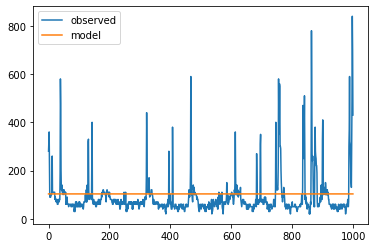

 74%|███████▍  | 37/50 [40:15<12:56, 59.69s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
61.03985482690068                                                                
 74%|███████▍  | 37/50 [40:42<12:56, 59.69s/trial, best loss: 59.189014998631365]

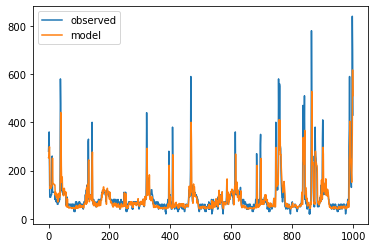

 76%|███████▌  | 38/50 [40:42<09:58, 49.88s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00065: early stopping                                                      
Best forecast loss of epoch:                                                     
60.03751387140946                                                                
 76%|███████▌  | 38/50 [41:35<09:58, 49.88s/trial, best loss: 59.189014998631365]

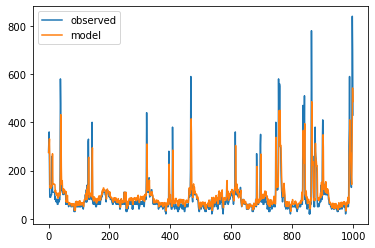

 78%|███████▊  | 39/50 [41:35<09:17, 50.71s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00038: early stopping                                                      
Best forecast loss of epoch:                                                     
59.813022669097485                                                               
 78%|███████▊  | 39/50 [42:33<09:17, 50.71s/trial, best loss: 59.189014998631365]

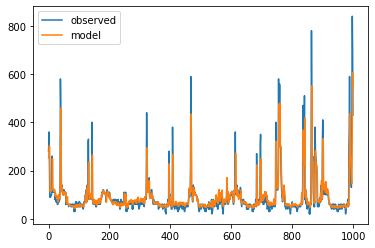

 80%|████████  | 40/50 [42:33<08:48, 52.87s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00072: early stopping                                                      
Best forecast loss of epoch:                                                     
60.933775826223155                                                               
 80%|████████  | 40/50 [43:36<08:48, 52.87s/trial, best loss: 59.189014998631365]

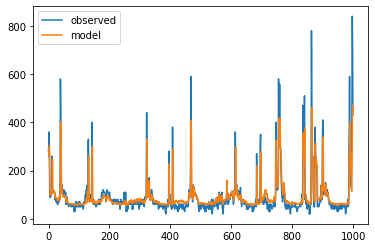

 82%|████████▏ | 41/50 [43:36<08:24, 56.05s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                      
Best forecast loss of epoch:                                                     
67.83752033345597                                                                
 82%|████████▏ | 41/50 [44:47<08:24, 56.05s/trial, best loss: 59.189014998631365]

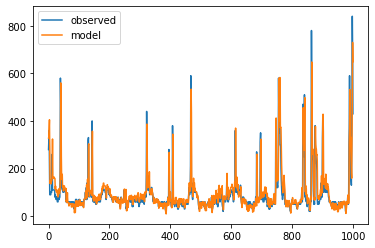

 84%|████████▍ | 42/50 [44:47<08:04, 60.55s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00046: early stopping                                                      
Best forecast loss of epoch:                                                     
59.30047813262002                                                                
 84%|████████▍ | 42/50 [45:27<08:04, 60.55s/trial, best loss: 59.189014998631365]

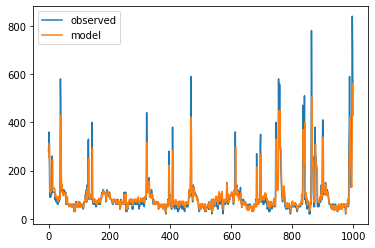

 86%|████████▌ | 43/50 [45:27<06:19, 54.28s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00041: early stopping                                                      
Best forecast loss of epoch:                                                     
61.592818787284365                                                               
 86%|████████▌ | 43/50 [46:01<06:19, 54.28s/trial, best loss: 59.189014998631365]

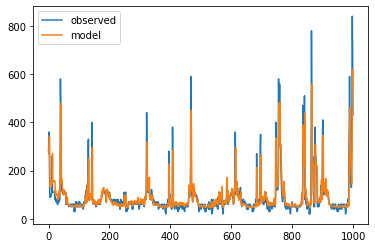

 88%|████████▊ | 44/50 [46:01<04:49, 48.25s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00035: early stopping                                                      
Best forecast loss of epoch:                                                     
64.68941226130399                                                                
 88%|████████▊ | 44/50 [46:18<04:49, 48.25s/trial, best loss: 59.189014998631365]

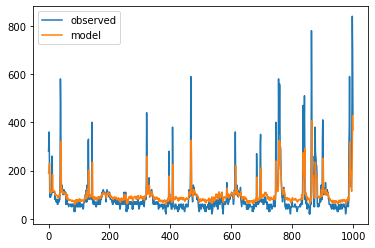

 90%|█████████ | 45/50 [46:18<03:14, 38.81s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00021: early stopping                                                      
Best forecast loss of epoch:                                                     
62.07561892760311                                                                
 90%|█████████ | 45/50 [47:00<03:14, 38.81s/trial, best loss: 59.189014998631365]

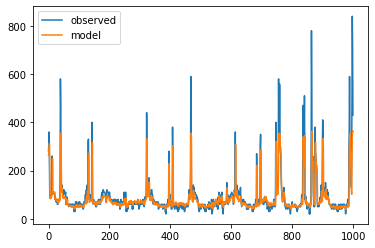

 92%|█████████▏| 46/50 [47:00<02:39, 39.95s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00042: early stopping                                                      
Best forecast loss of epoch:                                                     
60.34099683329244                                                                
 92%|█████████▏| 46/50 [47:23<02:39, 39.95s/trial, best loss: 59.189014998631365]

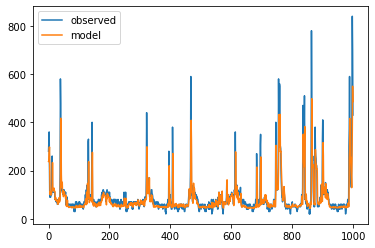

 94%|█████████▍| 47/50 [47:23<01:44, 34.81s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Best forecast loss of epoch:                                                     
60.4563954041468                                                                 
 94%|█████████▍| 47/50 [48:54<01:44, 34.81s/trial, best loss: 59.189014998631365]

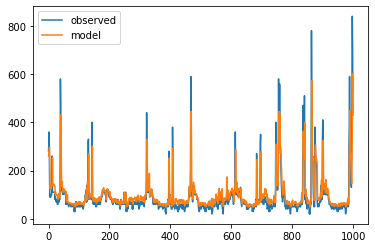

 96%|█████████▌| 48/50 [48:54<01:43, 51.62s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00047: early stopping                                                      
Best forecast loss of epoch:                                                     
68.15011455974883                                                                
 96%|█████████▌| 48/50 [50:01<01:43, 51.62s/trial, best loss: 59.189014998631365]

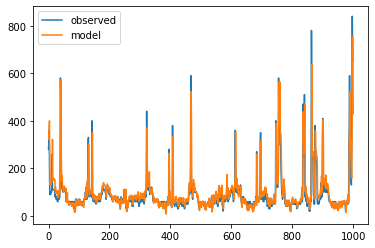

 98%|█████████▊| 49/50 [50:02<00:56, 56.36s/trial, best loss: 59.189014998631365]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00026: early stopping                                                      
Best forecast loss of epoch:                                                     
60.990318121682805                                                               
 98%|█████████▊| 49/50 [50:32<00:56, 56.36s/trial, best loss: 59.189014998631365]

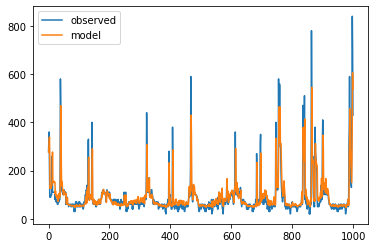

100%|██████████| 50/50 [50:32<00:00, 60.65s/trial, best loss: 59.189014998631365]


In [69]:
evals = 50
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=evals, trials=trials)

best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

In [70]:
best_model

In [71]:
best_params

{'activation': 'relu',
 'batch_size': 25,
 'epochs': 75,
 'layers': 4,
 'optimizer': 'adam',
 'rate': 0.36664190983068257,
 'units': 25}

In [72]:
worst_params

{'activation': 'sigmoid',
 'batch_size': 25,
 'epochs': 100,
 'layers': 4,
 'optimizer': 'adam',
 'rate': 0.3484864073930012,
 'units': 10}